# Capstone Project 20:1 - Classifying Fake News Initial Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import nltk
import string
import time

from IPython.display import Markdown, display

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from collections import Counter

nltk.download('words')
nltk.download('stopwords')

from gensim.models import KeyedVectors

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score , precision_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN, Flatten, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical

from lime.lime_text import LimeTextExplainer

from keras import backend as K

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
sns.set_palette("rocket")

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mpaci\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mpaci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="section1"></a>
# Part 1: Data Collection, Analysis and Preprocessing

<a id="section1A"></a>
## 1A: Data Collection 

The dataset to be used in this analysis is the [Fake News Classification Dataset](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification) from Kaggle.


In [2]:
df_original = pd.read_csv('data/WELFake_Dataset.csv')

In [3]:
df_original.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


<a id="section1B"></a>
## 1B: Dataset Cleaning

Before processing the actual contents of the text, we will perform a general clean up on the raw dataset.  This will include:

1. Remove unnecessary columns
2. Relabel column titles
3. Remove duplicate rows
4. Remove missing data from rows

First we will create a deep copy of the original dataframe before modifying the data: 

In [4]:
df_clean = df_original.copy()

### i) Remove unnecessary columns

In [5]:
df_clean['Unnamed: 0'].nunique()

72134

Kaggle dataset shows this column as the 'serial number', and as the number of unique values is equivalent to the number of entries, we can confidently equate this to just the index number.  This redundant column will be dropped.

In [6]:
df_clean = df_clean.drop(['Unnamed: 0'], axis=1)

### ii) Rename columns

After reviewing the comments on the Kaggle dataset and performing cross checks, the 'label' column is a binary classifier that determines whether the article is either:
1. Fake = 1
2. Real = 0

We will rename the label column and capitalize the other two column titles:

In [7]:
df_clean.columns = ['Title','Text','Fake']
df_clean.head()

,Title,Text,Fake
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


### iii) Remove duplicates

We don't want to train or test the model on duplicated information, as this will cause bias in the results weighted towards those duplicates. 

Instead of checking for duplicates of text AND title, we will check for duplicate titles and text separately, since there may be duplicate cases where the text or title is different, but the text or title is repeated in another entry. 

In [8]:
#Check how many duplicated titles there are
duplicate_titles = df_clean.duplicated(subset = ['Title','Fake'])
print('There are',duplicate_titles.sum(), 'entries with duplicated titles')

There are 9782 entries with duplicated titles


In [9]:
#Check how many duplicated bodies of text there are 
duplicate_text = df_clean.duplicated(subset = ['Text', 'Fake'])
duplicate_text.sum()
print('There are', duplicate_text.sum(), 'entries with duplicated text')

There are 9414 entries with duplicated text


In [10]:
#Remove duplicates
df_clean = df_clean.drop_duplicates(subset = ['Title','Fake'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62352 entries, 0 to 72132
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   62351 non-null  object
 1   Text    62313 non-null  object
 2   Fake    62352 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [11]:
#Remove duplicates
df_clean = df_clean.drop_duplicates(subset = ['Text','Fake'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61400 entries, 0 to 72132
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   61399 non-null  object
 1   Text    61399 non-null  object
 2   Fake    61400 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [12]:
print(f"Removing duplicates dropped {len(df_original) - len(df_clean):,} values from our original dataset, or {(len(df_original) - len(df_clean)) / len(df_original) * 100:.0f}% of the original dataset.")

Removing duplicates dropped 10,734 values from our original dataset, or 15% of the original dataset.


### iv) Remove missing data

We can see from the summary above that there is atleast 1 row of missing data in title and text. We will remove it below.

In [13]:
df_clean.dropna(inplace = True)

In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61398 entries, 0 to 72132
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   61398 non-null  object
 1   Text    61398 non-null  object
 2   Fake    61398 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


Now we have a clean dataset to manipulate and perform text pre-processing on.

### v) Review cleaned data and remove outliers

Before we do the text processing, we will take a broad look at the characteristics of the data to get more familiarized with it.

In order to get more familiarized with the cleaned data and to check if we need to do any further data cleaning, we will check and visualize the distribution of:
1. Classifications
2. Word Counts
3. Character Counts (includes letters, punctuation and spaces)
4. Unique Words

In [15]:
#Calculate word counts for the Text and Title columns separately
df_clean['Text Word Count'] = df_clean['Text'].apply(lambda text: len(str(text).split()))
df_clean['Title Word Count'] = df_clean['Title'].apply(lambda text: len(str(text).split()))

#Calculate respective character counts (including spaces and punctuation)
df_clean['Text Character Count'] = df_clean['Text'].apply(lambda text: len(str(text)))
df_clean['Title Character Count'] = df_clean['Title'].apply(lambda text: len(str(text)))

In [16]:
df_clean.head()

,Title,Text,Fake,Text Word Count,Title Word Count,Text Character Count,Title Character Count
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,871,18,5049,130
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,34,18,216,137
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,1321,16,8010,105
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,329,16,1916,95
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,244,13,1530,78


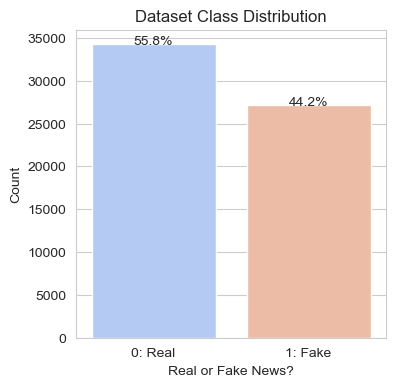

In [17]:
plt.figure(figsize=(4, 4))

ax = sns.countplot(x='Fake', data=df_clean, palette='coolwarm')

ax.set_title('Dataset Class Distribution', fontsize=12)
ax.set_xlabel('Real or Fake News?', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

ax.set_xticklabels(['0: Real', '1: Fake'])

# Calculate the total number of entries
total = len(df_clean)

# Add % annotations
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    ax.text(p.get_x() + p.get_width() / 2., height + 3, percentage, ha='center', fontsize=10)
    
plt.show()

From here we can see that we have a somewhat balanced dataset, with a slight bias towards real news (55% of samples) vs fake news (45% of samples).  As a result, we will need to consider more than just accuracy as an evaluation metric in order to asses model performance.

In [18]:
df_clean[['Text Word Count',
 'Title Word Count',
 'Text Character Count',
 'Title Character Count']].describe(percentiles=[0.01, 0.25, 0.75, 0.9]).applymap(lambda x: "{:,.0f}".format(x))

,Text Word Count,Title Word Count,Text Character Count,Title Character Count
count,"61,398","61,398","61,398","61,398"
mean,552,12,"3,334",75
std,611,4,"3,637",23
min,0,1,1,1
1%,22,5,137,30
25%,249,9,"1,512",61
50%,407,11,"2,490",72
75%,680,14,"4,132",87
90%,"1,107",17,"6,674",100
max,"24,234",72,"142,961",456


From this summary we can see that:
1. Titles on average are 12 words long, and 75 characters
2. Bodies of text are an average of 552 words long and 3,300 characters

There are some obvious outliers but overall the  in each, including some text that is 0 characters and some 1 word titles. 

To capture a wider range of nonsensical outliers, we will remove any samples that are smaller than the first percentile (<20 words for the article text, and <5 words for title).

In [19]:
#Calculate original number of entries
len_original = len(df_clean)

#Create boolean filter to filter for the opposite of our outlier conditions
filter = (df_clean['Text Word Count'] >= 20) & (df_clean['Title Word Count'] >= 5)

#Remove filtered data
df_clean = df_clean[filter]

#Calculate new length
len_new = len(df_clean)

#Change in length
len_change = len_new - len_original
len_change_percent = len_change / len_original *100

In [20]:
#Re-review sample to confirm outliers have been removed
df_clean[['Text Word Count',
 'Title Word Count',
 'Text Character Count',
 'Title Character Count']].describe(percentiles=[0.01, 0.25, 0.75, 0.9]).applymap(lambda x: "{:,.0f}".format(x))

,Text Word Count,Title Word Count,Text Character Count,Title Character Count
count,"60,410","60,410","60,410","60,410"
mean,554,12,"3,346",76
std,608,4,"3,614",22
min,20,5,95,19
1%,33,6,200,35
25%,255,9,"1,549",62
50%,409,11,"2,502",72
75%,681,14,"4,135",87
90%,"1,105",17,"6,658",100
max,"24,234",58,"142,961",396


In [21]:
print(f"Removing outliers dropped {-len_change:,} values from our original dataset, or {-len_change_percent:.0f}% of the original dataset.")

Removing outliers dropped 988 values from our original dataset, or 2% of the original dataset.


Below, we visualize the remain data to better see how the character and text count is distributed.

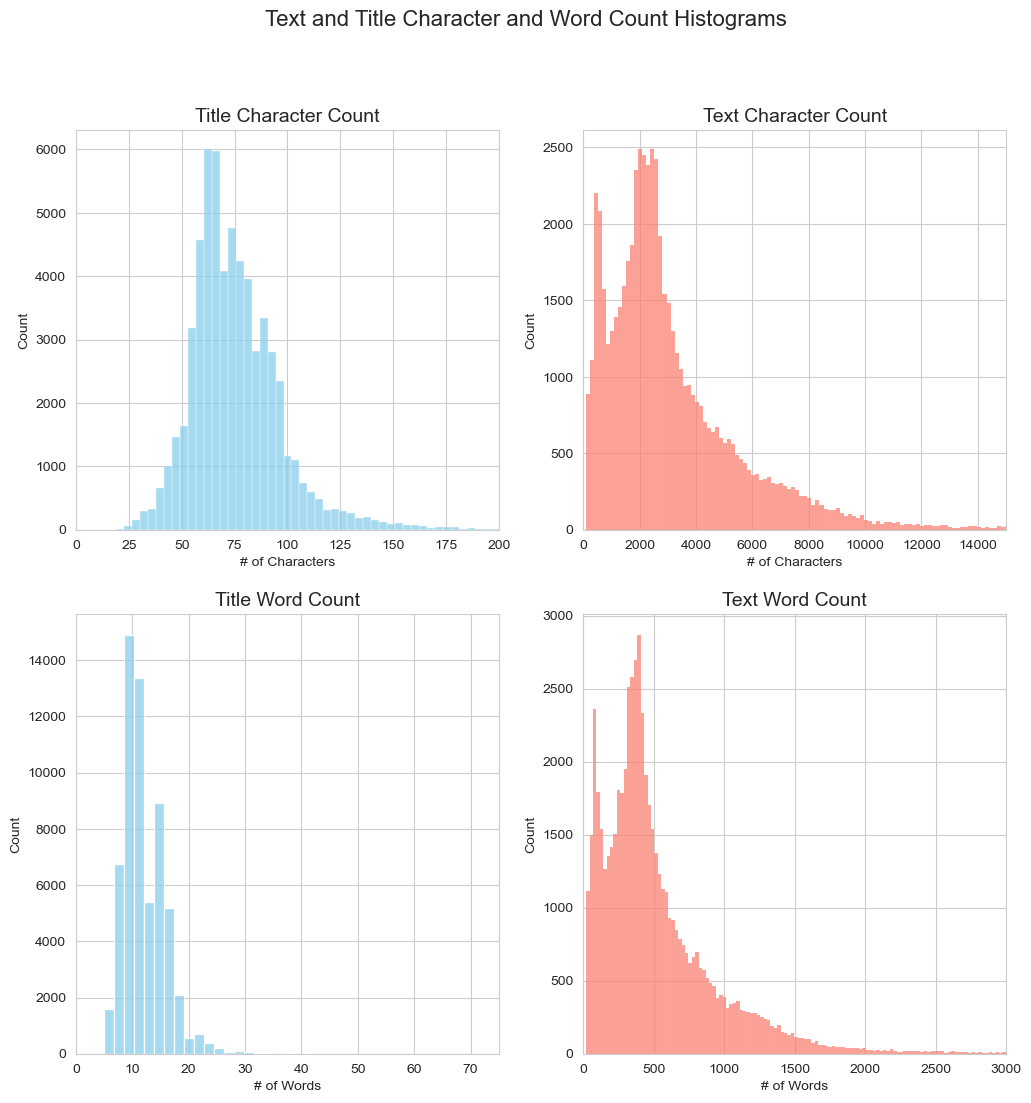

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1.1]})
fig.suptitle('Text and Title Character and Word Count Histograms', fontsize=16)

title_color = "skyblue"
text_color = "salmon"
title_size = 14

# Plot 1: Title Character Count
sns.histplot(df_clean['Title Character Count'], bins=100, ax=axs[0, 0], color=title_color)
axs[0, 0].set_title('Title Character Count', fontsize=title_size)
axs[0, 0].set_xlim(0, 200)
axs[0, 0].set_xlabel('# of Characters', fontsize=10)

# Plot 2: Text Character Count
sns.histplot(df_clean['Text Character Count'], bins=1000, ax=axs[0, 1], color=text_color)
axs[0, 1].set_title('Text Character Count', fontsize=title_size)
axs[0, 1].set_xlim(0, 15000)
axs[0, 1].set_xlabel('# of Characters', fontsize=10)

# Plot 3: Title Word Count
sns.histplot(df_clean['Title Word Count'], bins=30, ax=axs[1, 0], color=title_color)
axs[1, 0].set_title('Title Word Count', fontsize=title_size)
axs[1, 0].set_xlim(0, 75)
axs[1, 0].set_xlabel('# of Words', fontsize=10)

# Plot 4: Text Word Count
sns.histplot(df_clean['Text Word Count'], bins=1000, ax=axs[1, 1], color=text_color)
axs[1, 1].set_title('Text Word Count', fontsize=title_size)
axs[1, 1].set_xlim(0, 3000)
axs[1, 1].set_xlabel('# of Words', fontsize=10)

# Show the plot
plt.show()


From the description summary above and the following histograms, we can see that:
1. The text count is skewed to the to the left and has two peaks at around 250 words and 100 words per article
2. The title count is fairly normally distributed if we remove the upper outlies around 75 words per title.

This is interesting to see and might indicate that we will need to standardize or pad out the vectorized columns, depending on how many more words are removed, however for the moment we will not transform the distributions as we want to try and capture as many different types of articles as possible.  If the model is performing very poorly, we might consider this, but for now we will keep the data as is.

<a id="section1C"></a>
## 1C: Shrink Dataset

Due to the heavy computational resources required to process text data, I will shrink the dataset to a size that will be faster to process.

In [23]:
#First create a copy of the dataframe
df_clean_copy = df_clean.copy()

In [24]:
sample_size = 1000

In [25]:
df = df_clean_copy.sample(sample_size, random_state = 42).reset_index(drop=True)

Perform a quick check to see how the data is distributed in this smaller sample:

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  1000 non-null   object
 1   Text                   1000 non-null   object
 2   Fake                   1000 non-null   int64 
 3   Text Word Count        1000 non-null   int64 
 4   Title Word Count       1000 non-null   int64 
 5   Text Character Count   1000 non-null   int64 
 6   Title Character Count  1000 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 54.8+ KB


In [27]:
#Re-review sample to confirm outliers have been removed
df[['Text Word Count',
 'Title Word Count',
 'Text Character Count',
 'Title Character Count']].describe(percentiles=[0.01, 0.25, 0.75, 0.9]).applymap(lambda x: "{:,.0f}".format(x))

,Text Word Count,Title Word Count,Text Character Count,Title Character Count
count,"1,000","1,000","1,000","1,000"
mean,539,12,"3,258",76
std,538,4,"3,221",23
min,20,5,117,29
1%,42,6,253,37
25%,254,9,"1,547",62
50%,395,12,"2,402",72
75%,679,14,"4,102",88
90%,"1,073",17,"6,530",100
max,"6,628",38,"39,735",255


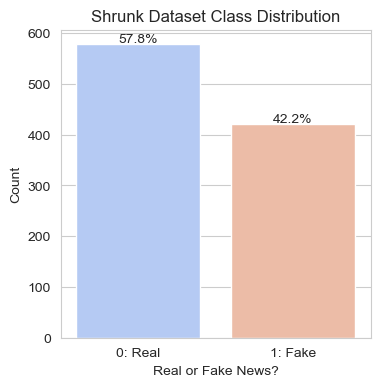

In [28]:
plt.figure(figsize=(4, 4))

ax = sns.countplot(x='Fake', data=df, palette='coolwarm')

ax.set_title('Shrunk Dataset Class Distribution', fontsize=12)
ax.set_xlabel('Real or Fake News?', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

ax.set_xticklabels(['0: Real', '1: Fake'])

# Calculate the total number of entries
total = len(df)

# Add % annotations
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    ax.text(p.get_x() + p.get_width() / 2., height + 3, percentage, ha='center', fontsize=10)
    
plt.show()

The distribution of our reduced sample size is similar to the original dataset (56/44% split), with slightly more skew towards Real news.

<a id="section1D"></a>
## 1D: Text Preprocessing

Before any further processing, we will remove the word and character count summaries from our dataframe:

In [29]:
df.drop(['Text Word Count',
 'Title Word Count',
 'Text Character Count',
 'Title Character Count'], axis = 1, inplace=True)

In order to review and process the model using machine learning methods from python, the text data needs to be converted to numerical data.

This requires the following steps:
1. Tokenize the text
2. Remove common stop words
3. Remove punctuation
4. Lemmatize words
- We are choosing lemmatize over stemming due to the nature of wanting to keep as much linguistic context of the text in the model as possible.  We want to be able to identify true or false news.  False news could have the same general content as true news, but subtle differences in word usage, which we hope to capture via lemmatization.

Note that in future iterations of the model, if we need to improve performance it might be worth replacing stop words and punctuation, as these could prove to be important in distinguishing between fake and real publications.  This would be similar to choosing lemmatization over stemming, however for now we will keep them removed to help speed up processing, and assess model performance before adding them back in.

In [30]:
def tokenize(text):
    # Tokenize only if the input is a string
    return word_tokenize(text) if isinstance(text, str) else []

def clean_tokens(tokens, stop_words, punc):
    # Combine the processing steps into a single function
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word not in punc]
    return tokens

# Initializing stop words, stemmer, lemmatizer, and punctuation list
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
extended_punc = list(string.punctuation) + ['“', '”', '’', '‘', '—', '``', "''",'–']

# Function to apply all text processing steps
def process_text_column(column):
    cleaned_tokens = column.apply(lambda x: clean_tokens(tokenize(x), stop_words, extended_punc))
    lemmatized = cleaned_tokens.apply(lambda tokens: [lemma.lemmatize(word) for word in tokens])
    return cleaned_tokens, lemmatized

# Apply text processing to both Title and Text columns
df['Cleaned Tokens Title'], df['Lemmatized Title'] = process_text_column(df['Title'])
df['Cleaned Tokens Text'], df['Lemmatized Text'] = process_text_column(df['Text'])

In [31]:
df.head()

,Title,Text,Fake,Cleaned Tokens Title,Lemmatized Title,Cleaned Tokens Text,Lemmatized Text
0,Lawyers Mobilize at Nation’s Airports After Tr...,Even before President Trump issued an order on...,0,"[lawyers, mobilize, nation, airports, trump, o...","[lawyer, mobilize, nation, airport, trump, ord...","[even, president, trump, issued, order, friday...","[even, president, trump, issued, order, friday..."
1,U.S. education secretary calls Obama transgend...,WASHINGTON (Reuters) - U.S. Education Secretar...,0,"[u.s., education, secretary, calls, obama, tra...","[u.s., education, secretary, call, obama, tran...","[washington, reuters, u.s., education, secreta...","[washington, reuters, u.s., education, secreta..."
2,Millions to lose health insurance under Republ...,WASHINGTON (Reuters) - Millions of Americans w...,0,"[millions, lose, health, insurance, republican...","[million, lose, health, insurance, republican,...","[washington, reuters, millions, americans, wou...","[washington, reuters, million, american, would..."
3,Trump RNC manager: 'Winning isn't enough',"""This is an example of Donald Trump managing, ...",0,"[trump, rnc, manager, 'winning, n't, enough]","[trump, rnc, manager, 'winning, n't, enough]","[example, donald, trump, managing, type, leade...","[example, donald, trump, managing, type, leade..."
4,Obama says protectionism no answer to inequali...,(Reuters) - America must work with all nations...,0,"[obama, says, protectionism, answer, inequalit...","[obama, say, protectionism, answer, inequality...","[reuters, america, must, work, nations, build,...","[reuters, america, must, work, nation, build, ..."


#### Visualise top words in each category

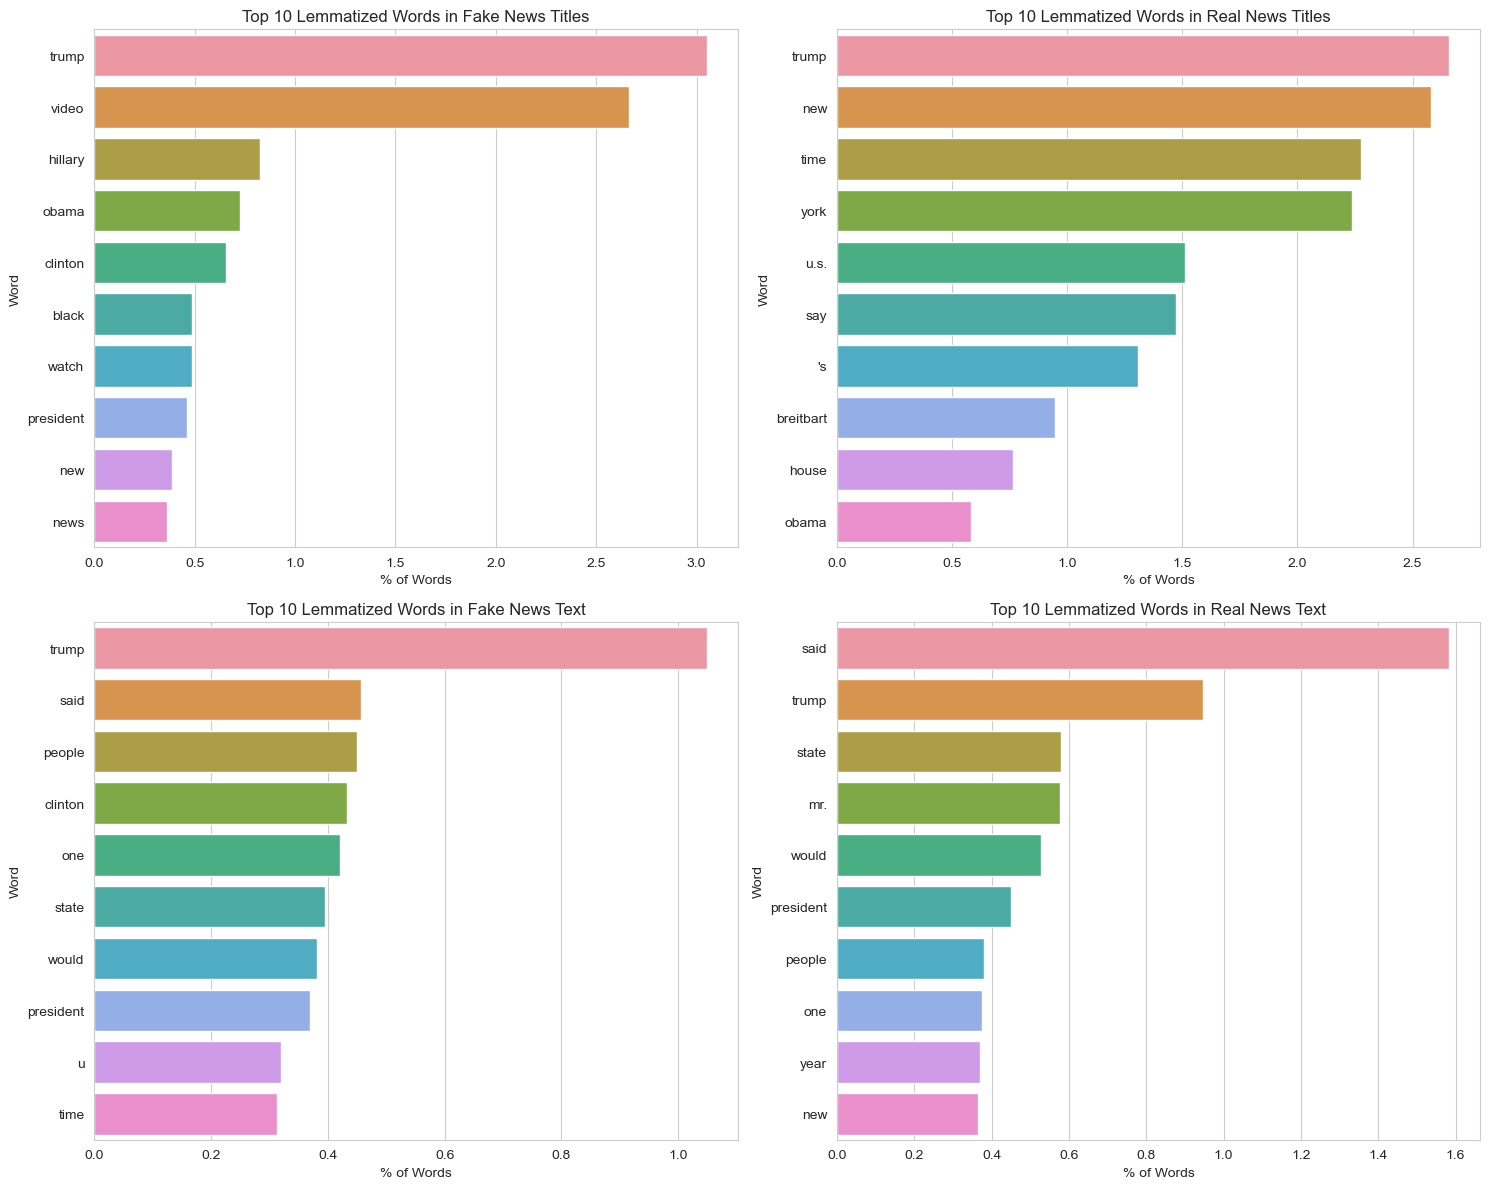

In [32]:
def plot_top_words(df, column, title, ax):
    # Sum all words in the column
    words = df[column].sum()
    total_words = len(words)
    word_counts = Counter(words)

    # Calculate the percentage of each word relative to the total word count
    top_words = {word: (count / total_words) * 100 for word, count in word_counts.most_common(10)}

    # Convert to DataFrame for plotting
    top_words_df = pd.DataFrame(list(top_words.items()), columns=['Word', '% of Words'])

    # Plot
    sns.barplot(y='Word', x='% of Words', data=top_words_df, ax=ax)
    ax.set_title(title)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Filter the DataFrame for Fake = 1 and Fake = 0 (Real)
df_fake_1 = df[df['Fake'] == 1]
df_fake_0 = df[df['Fake'] == 0]

# Call the function for each column and condition
plot_top_words(df_fake_1, 'Lemmatized Title', 'Top 10 Lemmatized Words in Fake News Titles', axs[0, 0])
plot_top_words(df_fake_1, 'Lemmatized Text', 'Top 10 Lemmatized Words in Fake News Text', axs[1, 0])
plot_top_words(df_fake_0, 'Lemmatized Title', 'Top 10 Lemmatized Words in Real News Titles', axs[0, 1])
plot_top_words(df_fake_0, 'Lemmatized Text', 'Top 10 Lemmatized Words in Real News Text', axs[1, 1])

plt.tight_layout()
plt.show()


Above we see some interesting summaries of what the main words are in each type of news article, and can discern the dataset appears to be centered around US politics, with a similar spread of topics between both fake and real news (Trump, president, state, people showing up in both categories).

<a id="section2"></a>
# Part 2: Modelling with Non-Neural Models

In the interest of time, for the X matrix, we will only use the tokenized title in the model and assess how the model performs.

If time permits, we will change the analysis to tokenized text, or a combination of title and text. 

<a id="section2A"></a>
## 2A:  Create X and y Dataframes

In order to perform modelling, we need to convert the tokenized words into numerical vectors.

In [33]:
#First join tokenized words back into a string, separating with spaces, as is required for tokenizing using Scikit Learn

X = [' '.join(token) for token in df['Lemmatized Title']]
y = df['Fake']

### Split X and y into test and train validation sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

<a id="section2B"></a>
## 2B: Calculate Baseline

As a first step to assessing our future models performance, we will create a baseline that our classifier should aim to beat.

Because this is a binary classification model, we will look at the accuracy of the model predicting the majority class for all data points as the baseline.

In [35]:
test_baseline = y_test.value_counts(normalize = True)
test_baseline

Fake
0    0.54
1    0.46
Name: proportion, dtype: float64

In [36]:
train_baseline = y_train.value_counts(normalize = True)
train_baseline

Fake
0    0.590667
1    0.409333
Name: proportion, dtype: float64

In [37]:
display(Markdown(f'In our case, where 0 = real news and 1 = fake news, we can define our baseline performance as {test_baseline[0]*100:.0f}% for the test datasets. \n\nThis means that if the model classified every single datapoint as the majority class ("Real"), then it would have ~ {test_baseline[0]*100:.0f}% accuracy.\n\nOur aim is to improve model performance beyond this.'))

In our case, where 0 = real news and 1 = fake news, we can define our baseline performance as 54% for the test datasets. 

This means that if the model classified every single datapoint as the majority class ("Real"), then it would have ~ 54% accuracy.

Our aim is to improve model performance beyond this.

<a id="section2C"></a>
## 2C: Cross Validate and Tune Different Models

### Methodology

Four machine learning algorithms that are commonly used for classifying binary data will be trained and tested on our news dataset.  These are our 'models':  
- i) Naive Bayes
- ii) Decision Tree
- iii) Logistic Regression
- iv) Support Vector Classification (SVC)


To assist with our model comparison we will assign a dataframe to collect results of each model.

In [38]:
results_df = pd.DataFrame(columns = ['Model','Train Duration', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1', 'Test PR AUC'])
results_df

,Model,Train Duration,Test Accuracy,Test Recall,Test Precision,Test F1,Test PR AUC


### Model Training

Per the methodology above, we train the four models discussed and collate their results:

### i) Naive Bayes

In [39]:
#Create a Naive Bayes model with  TF-IDF Vectorizer and Multinomial NaiveBayes
nb_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                       ('nb', MultinomialNB())])

#Define parameters for Grid Search
nb_params = {'nb__alpha' : [0,0.0001,0.001,0.01,0.1,1]}

#Define Grid
nb_grid = GridSearchCV(estimator = nb_pipe,
                       param_grid = nb_params,
                       scoring = 'f1')

#Fit Model
nb_start_time = time.time()
nb_grid.fit(X_train, y_train)
nb_duration = time.time() - nb_start_time

#Select best estimator to make predictions
nb_best = nb_grid.best_estimator_
y_pred = nb_best.predict(X_test)

#Score best estimator
nb_accuracy = accuracy_score(y_test, y_pred)
nb_recall = recall_score(y_test, y_pred)
nb_precision = precision_score(y_test, y_pred)
nb_f1 = f1_score(y_test, y_pred)

#Display Best Parameter
nb_params = nb_grid.best_params_
nb_params

{'nb__alpha': 0.1}

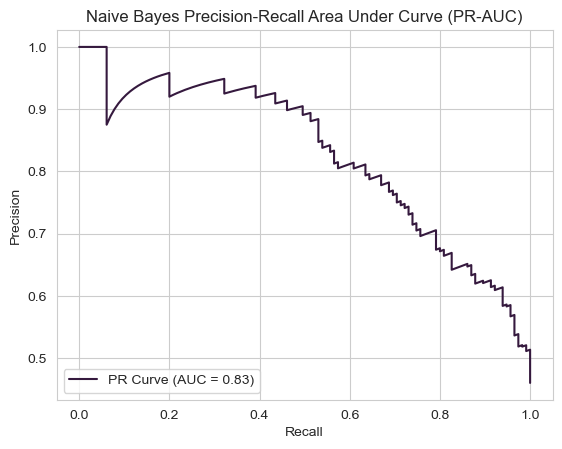

In [40]:
# Predict the probabilities
y_scores = nb_best.predict_proba(X_test)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate PR AUC
nb_pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure()
plt.plot(recall, precision, label='PR Curve (AUC = %0.2f)' % nb_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Naive Bayes Precision-Recall Area Under Curve (PR-AUC)')
plt.legend(loc="lower left")
plt.show()

In [41]:
nb_report = {
    'Model': 'Naive Bayes',
    'Train Duration': nb_duration,
    'Test Accuracy': nb_accuracy,
    'Test Recall': nb_recall,
    'Test Precision': nb_precision,
    'Test F1': nb_f1,
    'Test PR AUC': nb_pr_auc}


#results_df = results_df.append(nb_report, ignore_index=True).round(3)
nb_report = pd.DataFrame([nb_report])
results_df = pd.concat([results_df, nb_report], ignore_index=True).round(3)
results_df

,Model,Train Duration,Test Accuracy,Test Recall,Test Precision,Test F1,Test PR AUC
0,Naive Bayes,0.348,0.744,0.583,0.807,0.677,0.826


### ii) Decision Tree

In [42]:
#Create a Decision Tree model with  TF-IDF Vectorizer and DecisionTreeClassifier
dt_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                    ('tree', DecisionTreeClassifier())])

#Define parameters for Grid Search
dt_params = {'tree__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
             'tree__criterion': ['gini','entropy'],
             'tree__max_depth' : [1, 2, 3, 4],
             'tree__min_samples_split' : [1, 2, 3, 4]}
                    
                    
#Define Grid
dt_grid = GridSearchCV(estimator = dt_pipe,
                       param_grid = dt_params,
                       scoring = 'f1')

#Fit Model
dt_start_time = time.time()
dt_grid.fit(X_train, y_train)
dt_duration = time.time() - dt_start_time

#Select best estimator to make predictions
dt_best = dt_grid.best_estimator_
y_pred = dt_best.predict(X_test)

#Score best estimator
dt_accuracy = accuracy_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_f1 = f1_score(y_test, y_pred)

#Display Best Parameter
dt_params = dt_grid.best_params_
dt_params

{'tree__criterion': 'gini',
 'tree__max_depth': 4,
 'tree__min_impurity_decrease': 0.01,
 'tree__min_samples_split': 2}

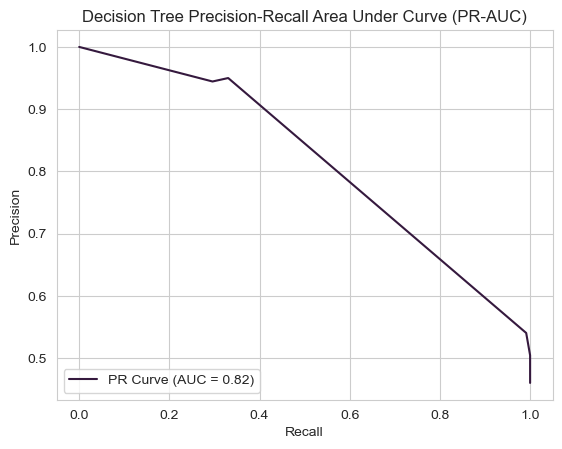

In [43]:
# Predict the probabilities
y_scores = dt_best.predict_proba(X_test)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate PR AUC
dt_pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure()
plt.plot(recall, precision, label='PR Curve (AUC = %0.2f)' % dt_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Decision Tree Precision-Recall Area Under Curve (PR-AUC)')
plt.legend(loc="lower left")
plt.show()

In [44]:
dt_report = {
    'Model': 'Decision Tree',
    'Train Duration': dt_duration,
    'Test Accuracy': dt_accuracy,
    'Test Recall': dt_recall,
    'Test Precision': dt_precision,
    'Test F1': dt_f1,
    'Test PR AUC': dt_pr_auc}

dt_report = pd.DataFrame([dt_report])
results_df = pd.concat([results_df, dt_report], ignore_index=True).round(3)
results_df

,Model,Train Duration,Test Accuracy,Test Recall,Test Precision,Test F1,Test PR AUC
0,Naive Bayes,0.348,0.744,0.583,0.807,0.677,0.826
1,Decision Tree,8.689,0.684,0.330,0.950,0.490,0.817


### iii) Logistic Regression

In [45]:
#Create a Logistic Regression model with  TF-IDF Vectorizer and a Logistic Regression object
lr_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LogisticRegression())])

#Define parameters for Grid Search
lr_params = {'lr__fit_intercept': [True,False],
             'lr__class_weight': [None, 'balanced'],
             'lr__penalty': ['none','l1','l2']}
                    
                    
#Define Grid
lr_grid = GridSearchCV(estimator = lr_pipe,
                       param_grid = lr_params,
                       scoring = 'f1')

#Fit Model
lr_start_time = time.time()
lr_grid.fit(X_train, y_train)
lr_duration = time.time() - lr_start_time

#Select best estimator to make predictions
lr_best = lr_grid.best_estimator_
y_pred = lr_best.predict(X_test)

#Score best estimator
lr_accuracy = accuracy_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)

#Display Best Parameter
lr_params = lr_grid.best_params_
lr_params

{'lr__class_weight': 'balanced',
 'lr__fit_intercept': False,
 'lr__penalty': 'l2'}

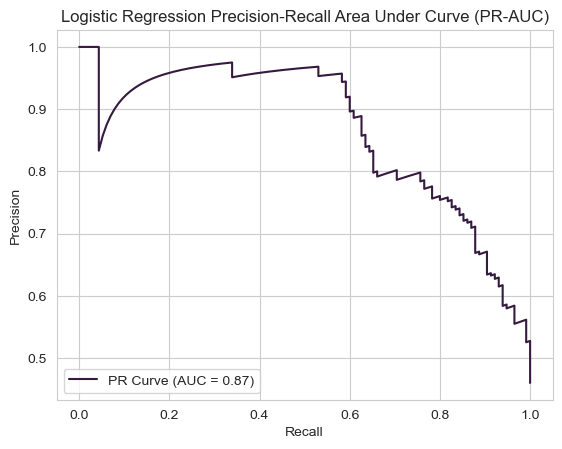

In [46]:
# Predict the probabilities
y_scores = lr_best.predict_proba(X_test)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate PR AUC
lr_pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure()
plt.plot(recall, precision, label='PR Curve (AUC = %0.2f)' % lr_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression Precision-Recall Area Under Curve (PR-AUC)')
plt.legend(loc="lower left")
plt.show()

In [47]:
lr_report = {
    'Model': 'Logistic Regression',
    'Train Duration': lr_duration,
    'Test Accuracy': lr_accuracy,
    'Test Recall': lr_recall,
    'Test Precision': lr_precision,
    'Test F1': lr_f1,
    'Test PR AUC': lr_pr_auc}

lr_report = pd.DataFrame([lr_report])
results_df = pd.concat([results_df, lr_report], ignore_index=True).round(3)
results_df

,Model,Train Duration,Test Accuracy,Test Recall,Test Precision,Test F1,Test PR AUC
0,Naive Bayes,0.348,0.744,0.583,0.807,0.677,0.826
1,Decision Tree,8.689,0.684,0.330,0.950,0.490,0.817
2,Logistic Regression,0.883,0.796,0.765,0.786,0.775,0.865


### iv) SVC

In [48]:
#Create a Support Vector Classification model with  TF-IDF Vectorizer and SVC object that records probabilities
svc_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                    ('svc', SVC(probability=True))])

#Define parameters for Grid Search
#Kernel and Gamma are hashed out due to time processing constraints.  These can be uncommented in the future for furhter analysis.
svc_params = {#'svc__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
              #'svc__gamma': [0.1, 1.0, 10.0, 100.0]
              'svc__C': [0.1, 1, 100]
             }

                    
#Define Grid
svc_grid = GridSearchCV(estimator = svc_pipe,
                        param_grid = svc_params,
                        scoring = 'f1')

#Fit Model
svc_start_time = time.time()
svc_grid.fit(X_train, y_train)
svc_duration = time.time() - svc_start_time

#Select best estimator to make predictions
svc_best = svc_grid.best_estimator_
y_pred = svc_best.predict(X_test)

#Score best estimator
svc_accuracy = accuracy_score(y_test, y_pred)
svc_recall = recall_score(y_test, y_pred)
svc_precision = precision_score(y_test, y_pred)
svc_f1 = f1_score(y_test, y_pred)

#Display Best Parameter
svc_params = svc_grid.best_params_
svc_params

{'svc__C': 100}

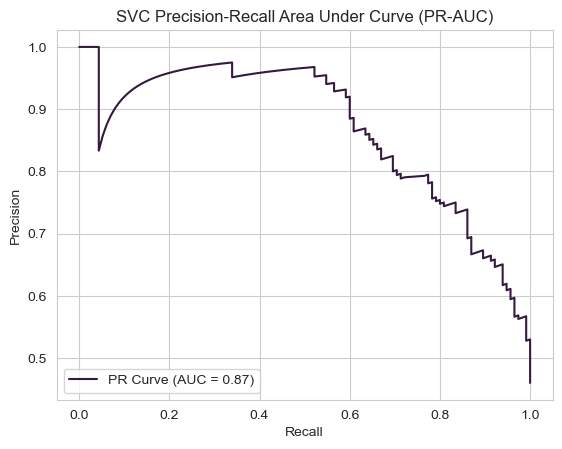

In [49]:
# Predict the probabilities
y_scores = svc_best.predict_proba(X_test)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate PR AUC
svc_pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure()
plt.plot(recall, precision, label='PR Curve (AUC = %0.2f)' % svc_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVC Precision-Recall Area Under Curve (PR-AUC)')
plt.legend(loc="lower left")
plt.show()

In [50]:
svc_report = {
    'Model': 'SVC',
    'Train Duration': svc_duration,
    'Test Accuracy': svc_accuracy,
    'Test Recall': svc_recall,
    'Test Precision': svc_precision,
    'Test F1': svc_f1,
    'Test PR AUC': svc_pr_auc}

svc_report = pd.DataFrame([svc_report])
results_df = pd.concat([results_df, svc_report], ignore_index=True).round(3)
results_df

,Model,Train Duration,Test Accuracy,Test Recall,Test Precision,Test F1,Test PR AUC
0,Naive Bayes,0.348,0.744,0.583,0.807,0.677,0.826
1,Decision Tree,8.689,0.684,0.330,0.950,0.490,0.817
2,Logistic Regression,0.883,0.796,0.765,0.786,0.775,0.865
3,SVC,2.115,0.784,0.635,0.859,0.730,0.867


<a id="section2D"></a>
### 2D: Model Review and Selection

After running our models, we can see that the best performing model based on the highest F1 score was the **Logistic Regression** model, tuned to its best performing hyperparameters of:
- Intercept set to 0
- L2 regularization
    - This is a technique used to prevent overfitting in the model, by using a term to penalize excessively complex parameters in the model.
- Balanced class weight
    - This weights each of the classes to reduce bias towards the more prevalent class.

This resulted in a model with an **F1 score of 0.775**, which we can interpret specifically in terms of number of False Negatives and False Positives using the below confusion matrix.  
- The matrix below shows that out of the 250 test samples, there were:
    - 24 False Positives (Real news incorrectly identified as Fake)
    - 27 False Negatives (Fake news incorrectly identified as Real)
    
    
This F1 score provides the best balance of minimizing both False Positive and False Negative results out of all of our models.

We also see that it has a relatively high PR-AUC score of 0.865, meaning it should perform well across different thresholds, if future analysis and tuning required it.

As a comparison to our original baseline, we can see that the corresponding accuracy score of 0.796 far exceeds the baseline of 0.54.  However, this improvement to the baseline was a trend seen generally across most models, and not particularly important compared to the more relevant F1 score metric.

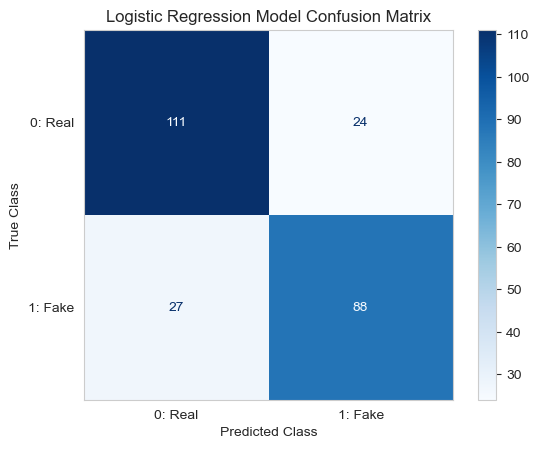

In [51]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, lr_best.predict(X_test))

#Extract false positives
lr_FP = conf_matrix[0][1]
#Extract false negatives
lr_FN = conf_matrix[1][0]

# Plot the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0: Real', '1: Fake']).plot(values_format='d', cmap='Blues')
plt.title('Logistic Regression Model Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.grid(False)
plt.show()


In order to interpret the F1 scores in a more explicit way, we will plot the confusion matrices for all the remaining models for later discussions:

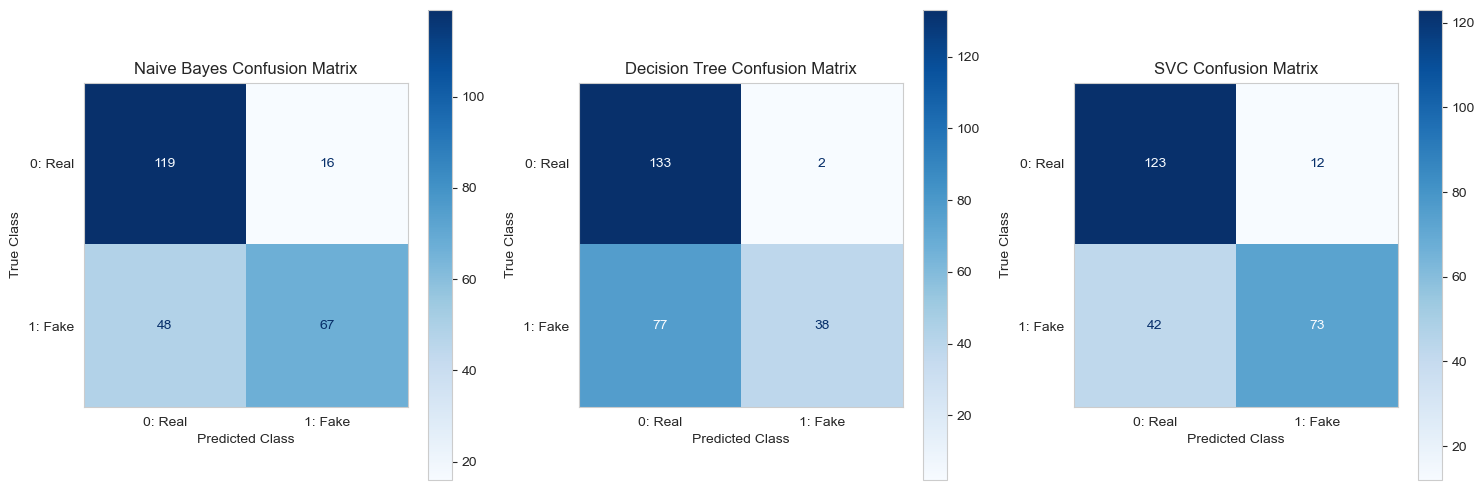

In [52]:
# Generate the confusion matrix
nb_conf_matrix = confusion_matrix(y_test, nb_best.predict(X_test))
dt_conf_matrix = confusion_matrix(y_test, dt_best.predict(X_test))
svc_conf_matrix = confusion_matrix(y_test, svc_best.predict(X_test))

# Create a figure for subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot each confusion matrix
ConfusionMatrixDisplay(confusion_matrix=nb_conf_matrix, display_labels=['0: Real', '1: Fake']).plot(values_format='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Naive Bayes Confusion Matrix')
ax[0].set_ylabel('True Class')
ax[0].set_xlabel('Predicted Class')
ax[0].grid(False)

ConfusionMatrixDisplay(confusion_matrix=dt_conf_matrix, display_labels=['0: Real', '1: Fake']).plot(values_format='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Decision Tree Confusion Matrix')
ax[1].set_ylabel('True Class')
ax[1].set_xlabel('Predicted Class')
ax[1].grid(False)

ConfusionMatrixDisplay(confusion_matrix=svc_conf_matrix, display_labels=['0: Real', '1: Fake']).plot(values_format='d', cmap='Blues', ax=ax[2])
ax[2].set_title('SVC Confusion Matrix')
ax[2].set_ylabel('True Class')
ax[2].set_xlabel('Predicted Class')
ax[2].grid(False)

# Adjust layout
plt.tight_layout()
plt.show()

<a id="section3"></a>
# Part 3: Modelling with Recurrent Neural Network (RNN) Model

<a id="section3A"></a>
## 3A: Motivation

As we can see, even after tuning hyperparameters to extract the best models, we had a best case scenario of 0.775 for the F1 score.

With a maximum possible score of 1, there is definitely still room for improvement.  

The limitations of using non-neural networking is that we are processing the text into numbers that only represent their frequency and uniqueness to the text. The challenge of detecting fake news is that both fake and real news can often contain much of the same content, and be written in similar syntax.  They may only be separate subtle changes in context, order of facts and language (such as DID vs DID NOT), and less commonly these days by improper punctuation or spelling, as well as sensationalist vocabulary.

<a id="section3B"></a>
## 3B: Additional Preprocessing of X and y Dataframes

The first step is to perform additional preprocessing on the X and y dataframes into formats that are appropriate for the RNN models available within python.

### i) Recreate X and y matrices
This time we will take the lemmatized text column, in place of lemmatized title.

In [53]:
#First join tokenized words back into a string, separating with spaces, as is required for tokenizing using Scikit Learn

X = [' '.join(token) for token in df['Lemmatized Text']]
y = df['Fake']

### ii) Tokenize the X dataframe and calculate vocabulary size
Vocabulary size will be used below to re-initialize the tokenizer.

In [54]:
# Initialize the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# Size of the Vocabulary
vocab_size = len(tokenizer.word_index) + 1  #Adding 1 because index 0 is reserved

print("Vocabulary size:", vocab_size)

Vocabulary size: 26351


### iii) Calculate the max sample length
This will be used in the next step to ensure all sequences have a consistent length, as required for neural network processing

In [55]:
# Tokenize the text
sequences = tokenizer.texts_to_sequences(X)

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Determine an appropriate max_length
# For example, set max_length to the 90th percentile of sequence lengths
max_length = int(np.percentile(sequence_lengths, 90))

print("Chosen max_length:", max_length)

Chosen max_length: 630


### iv) Re-initalize Tokenizer and pad the dataframe
Tokenizer: This is done to ensure that the vocabulary size and ID remains consistent between training and test data tokenization.

Padding: This done to ensure that each sample is a consistent size, which is required for efficient batch processing. It is set to the max sample length we calculated above.

In [56]:
# Re-initialize the tokenizer with the vocabulary size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length)


### v) Recreate x using the pre-processed dataframe

In [57]:
X = padded_sequences

In [58]:
X

array([[    0,     0,     0, ...,   128,   724,   414],
       [    0,     0,     0, ...,   234,   499,    72],
       [    0,     0,     0, ...,    20,   273,  2972],
       ...,
       [    0,     0,     0, ...,   823, 26345, 26346],
       [    0,     0,     0, ...,  1041,  3990,   401],
       [    0,     0,     0, ...,   492,   141,  7560]])

### vi) Convert y to an array
This is required for neural network processing.

In [59]:
y = df['Fake'].values

### vii) Split the newly tokenized X dataframe 

In [60]:
#Create index trackers (idx_train and idx_test) so that we can compare final results with the original raw text entries

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df.index, random_state=22)

Check the size of the training sets to make sure they have been padded to the max length.

In [61]:
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (750, 630)
Testing set size: (250, 630)


<a id="section3C"></a>
## 3C: Cross Validate and Tune Model

### i) Set Embedding Dimensions

In [62]:
embedding_dim = 50

### ii) Compile Sequential Recurrent Neural Network (RNN) Model

In [63]:
#Build a function to be able to run the RNN model through GridSearchCV.  
#Input is neurons, which will the parameter to alter
#Select random seed 42 to make sure results are as repeatable as possible
tf.random.set_seed(42)

def build_rnn_model(neurons):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(neurons))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision(), Recall()])
    return model


In [64]:
#Instantiate the model
rnn_model = KerasClassifier(build_fn=build_rnn_model)
                        
#Define parameters for Grid Search
params = {'neurons': [5, 16, 32],
          'epochs': [5,10]}

#Define Grid
rnn_grid = GridSearchCV(estimator = rnn_model,
                        param_grid=params,
                        scoring = 'f1')

In [65]:
#Fit Model
rnn_start_time = time.time()
rnn_grid.fit(X_train, y_train)
rnn_duration = time.time() - rnn_start_time

Epoch 1/5
19/19 [==============================] - 3s 93ms/step - loss: 0.6844 - accuracy: 0.6733 - precision: 0.7345 - recall: 0.3333
Epoch 2/5
19/19 [==============================] - 2s 94ms/step - loss: 0.6387 - accuracy: 0.7650 - precision: 1.0000 - recall: 0.4337
Epoch 3/5
19/19 [==============================] - 2s 94ms/step - loss: 0.5653 - accuracy: 0.8917 - precision: 1.0000 - recall: 0.7390
Epoch 4/5
19/19 [==============================] - 2s 94ms/step - loss: 0.4613 - accuracy: 0.9550 - precision: 1.0000 - recall: 0.8916
Epoch 5/5
5/5 [==============================] - 0s 19ms/step
Epoch 1/5
19/19 [==============================] - 3s 101ms/step - loss: 0.6799 - accuracy: 0.6783 - precision_1: 0.7473 - recall_1: 0.2857
Epoch 2/5
19/19 [==============================] - 2s 94ms/step - loss: 0.6206 - accuracy: 0.7183 - precision_1: 1.0000 - recall_1: 0.2899
Epoch 3/5
19/19 [==============================] - 2s 94ms/step - loss: 0.5091 - accuracy: 0.8800 - precision_1: 1.0000

5/5 [==============================] - 0s 30ms/step
Epoch 1/5
19/19 [==============================] - 3s 104ms/step - loss: 0.6823 - accuracy: 0.6483 - precision_11: 0.7213 - recall_11: 0.1849
Epoch 2/5
19/19 [==============================] - 2s 106ms/step - loss: 0.6000 - accuracy: 0.6333 - precision_11: 1.0000 - recall_11: 0.0756
Epoch 3/5
19/19 [==============================] - 2s 106ms/step - loss: 0.3644 - accuracy: 0.8550 - precision_11: 1.0000 - recall_11: 0.6345
Epoch 4/5
19/19 [==============================] - 2s 107ms/step - loss: 0.1756 - accuracy: 0.9967 - precision_11: 1.0000 - recall_11: 0.9916
Epoch 5/5
5/5 [==============================] - 0s 33ms/step
Epoch 1/5
19/19 [==============================] - 4s 106ms/step - loss: 0.6803 - accuracy: 0.6100 - precision_12: 0.6250 - recall_12: 0.0826
Epoch 2/5
19/19 [==============================] - 2s 107ms/step - loss: 0.5807 - accuracy: 0.6350 - precision_12: 1.0000 - recall_12: 0.0950
Epoch 3/5
19/19 [=================

19/19 [==============================] - 2s 95ms/step - loss: 0.4127 - accuracy: 0.9800 - precision_18: 1.0000 - recall_18: 0.9520
Epoch 6/10
19/19 [==============================] - 2s 103ms/step - loss: 0.3415 - accuracy: 0.9967 - precision_18: 1.0000 - recall_18: 0.9920
Epoch 7/10
19/19 [==============================] - 2s 94ms/step - loss: 0.2952 - accuracy: 1.0000 - precision_18: 1.0000 - recall_18: 1.0000
Epoch 8/10
19/19 [==============================] - 2s 93ms/step - loss: 0.2601 - accuracy: 1.0000 - precision_18: 1.0000 - recall_18: 1.0000
Epoch 9/10
19/19 [==============================] - 2s 94ms/step - loss: 0.2311 - accuracy: 1.0000 - precision_18: 1.0000 - recall_18: 1.0000
Epoch 10/10
5/5 [==============================] - 0s 21ms/step
Epoch 1/10
19/19 [==============================] - 3s 92ms/step - loss: 0.6819 - accuracy: 0.6600 - precision_19: 0.6772 - recall_19: 0.3454
Epoch 2/10
19/19 [==============================] - 2s 94ms/step - loss: 0.6306 - accuracy: 0.

5/5 [==============================] - 0s 22ms/step
Epoch 1/10
19/19 [==============================] - 3s 95ms/step - loss: 0.6825 - accuracy: 0.6083 - precision_24: 0.5897 - recall_24: 0.1847
Epoch 2/10
19/19 [==============================] - 2s 98ms/step - loss: 0.6144 - accuracy: 0.6517 - precision_24: 1.0000 - recall_24: 0.1606
Epoch 3/10
19/19 [==============================] - 2s 101ms/step - loss: 0.3999 - accuracy: 0.8033 - precision_24: 1.0000 - recall_24: 0.5261
Epoch 4/10
19/19 [==============================] - 2s 98ms/step - loss: 0.1962 - accuracy: 0.9900 - precision_24: 1.0000 - recall_24: 0.9759
Epoch 5/10
19/19 [==============================] - 2s 103ms/step - loss: 0.1216 - accuracy: 1.0000 - precision_24: 1.0000 - recall_24: 1.0000
Epoch 6/10
19/19 [==============================] - 2s 108ms/step - loss: 0.0832 - accuracy: 1.0000 - precision_24: 1.0000 - recall_24: 1.0000
Epoch 7/10
19/19 [==============================] - 2s 97ms/step - loss: 0.0595 - accuracy: 1

19/19 [==============================] - 2s 118ms/step - loss: 0.1064 - accuracy: 1.0000 - precision_29: 1.0000 - recall_29: 1.0000
Epoch 6/10
19/19 [==============================] - 2s 117ms/step - loss: 0.0635 - accuracy: 1.0000 - precision_29: 1.0000 - recall_29: 1.0000
Epoch 7/10
19/19 [==============================] - 2s 116ms/step - loss: 0.0402 - accuracy: 1.0000 - precision_29: 1.0000 - recall_29: 1.0000
Epoch 8/10
19/19 [==============================] - 2s 125ms/step - loss: 0.0281 - accuracy: 0.9983 - precision_29: 0.9960 - recall_29: 1.0000
Epoch 9/10
19/19 [==============================] - 2s 117ms/step - loss: 0.0314 - accuracy: 0.9983 - precision_29: 1.0000 - recall_29: 0.9960
Epoch 10/10
5/5 [==============================] - 0s 31ms/step
Epoch 1/10
24/24 [==============================] - 4s 110ms/step - loss: 0.6787 - accuracy: 0.5853 - precision_30: 0.3750 - recall_30: 0.0195
Epoch 2/10
24/24 [==============================] - 3s 110ms/step - loss: 0.5407 - accura

In [66]:
#Extract hyperparameters from the best estimator
rnn_params = rnn_grid.best_params_
rnn_params_df = pd.DataFrame([rnn_params])
best_epochs = rnn_params_df.iloc[:,0].item()
best_neurons = rnn_params_df.iloc[:,1].item()

rnn_params

{'epochs': 10, 'neurons': 32}

<a id="section3D"></a>
## 3D: Model Review and Comparison

### i) Evalute Best RNN Model Performance

In [67]:
display(Markdown(f"Based on the GridSearchCV method above, the optimal number for increasing our F1 score is {best_epochs} training epochs, and neurons for the LSTM layer is {best_neurons}.\n\n We will retrain our model using these parameters below so we can visualize and analyse its performance over the training epochs:"))

Based on the GridSearchCV method above, the optimal number for increasing our F1 score is 10 training epochs, and neurons for the LSTM layer is 32.

 We will retrain our model using these parameters below so we can visualize and analyse its performance over the training epochs:

In [68]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(best_neurons))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision(), Recall()])

In [69]:
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
24/24 [==============================] - 5s 133ms/step - loss: 0.6811 - accuracy: 0.6027 - precision_31: 0.5849 - recall_31: 0.1010 - val_loss: 0.6624 - val_accuracy: 0.5800 - val_precision_31: 1.0000 - val_recall_31: 0.0870
Epoch 2/10
24/24 [==============================] - 3s 116ms/step - loss: 0.5557 - accuracy: 0.6493 - precision_31: 1.0000 - recall_31: 0.1433 - val_loss: 0.4622 - val_accuracy: 0.7640 - val_precision_31: 1.0000 - val_recall_31: 0.4870
Epoch 3/10
24/24 [==============================] - 3s 117ms/step - loss: 0.2509 - accuracy: 0.9707 - precision_31: 0.9931 - recall_31: 0.9349 - val_loss: 0.3309 - val_accuracy: 0.8960 - val_precision_31: 0.9238 - val_recall_31: 0.8435
Epoch 4/10
24/24 [==============================] - 3s 120ms/step - loss: 0.1199 - accuracy: 0.9973 - precision_31: 1.0000 - recall_31: 0.9935 - val_loss: 0.3119 - val_accuracy: 0.8800 - val_precision_31: 0.9126 - val_recall_31: 0.8174
Epoch 5/10
24/24 [==============================] - 3s 1

Below we manually calculate the F1 score, since it is not part of Tensorflow metric database.

In [70]:
#Reset column names after epoch training
history_df = pd.DataFrame(history.history)
new_column_names = ['loss',
 'accuracy',
 'precision',
 'recall',
 'val_loss',
 'val_accuracy',
 'val_precision',
 'val_recall']
history_df.columns = new_column_names

In [71]:
# Calculating F1 score
history_df['f1_train'] = 2 * (history_df['precision'] * history_df['recall']) / (history_df['precision'] + history_df['recall'])
history_df['f1_val'] = 2 * (history_df['val_precision'] * history_df['val_recall']) / (history_df['val_precision'] + history_df['val_recall'])


Below we visualize the performance of the model over the training epochs based on each of our metrics.

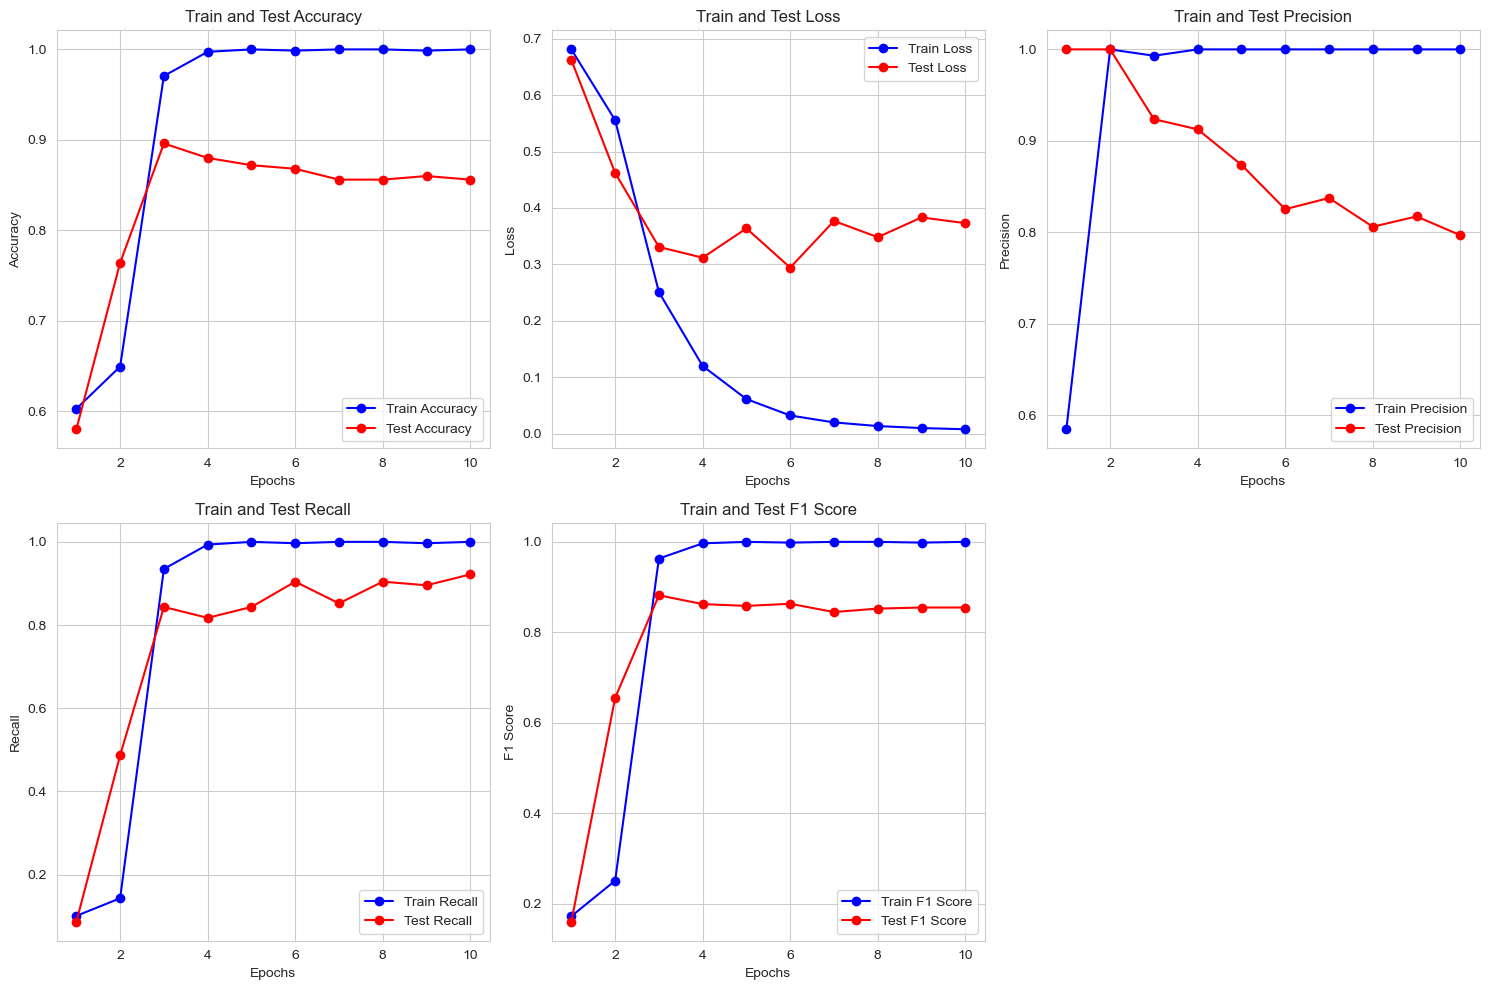

In [72]:
epochs = range(1, len(history_df) + 1)

plt.figure(figsize=(15, 10))

# Plotting Accuracy
plt.subplot(2, 3, 1)
plt.plot(epochs, history_df['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(epochs, history_df['val_accuracy'], 'ro-', label='Test Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(2, 3, 2)
plt.plot(epochs, history_df['loss'], 'bo-', label='Train Loss')
plt.plot(epochs, history_df['val_loss'], 'ro-', label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Precision
plt.subplot(2, 3, 3)
plt.plot(epochs, history_df['precision'], 'bo-', label='Train Precision')
plt.plot(epochs, history_df['val_precision'], 'ro-', label='Test Precision')
plt.title('Train and Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting Recall
plt.subplot(2, 3, 4)
plt.plot(epochs, history_df['recall'], 'bo-', label='Train Recall')
plt.plot(epochs, history_df['val_recall'], 'ro-', label='Test Recall')
plt.title('Train and Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting F1 Score
plt.subplot(2, 3, 5)
plt.plot(epochs, history_df['f1_train'], 'bo-', label='Train F1 Score')
plt.plot(epochs, history_df['f1_val'], 'ro-', label='Test F1 Score')
plt.title('Train and Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


Note that due to the nature of neural networks, these results will change slightly each time this notebook is run.

However as we can see, despite the gridsearch method to find optimal paramters, the model starts to perform perfectly on all metrics when fitting the training data as the number of epochs increase, indicating that our model is starting to overfit after several epochs.

As with most machine learning, the more the model starts to overfit the training data, the less well it generalizes on new unseen data, which we can see in the 'Train and Test Loss' graph, which shows that the Test loss starts to increase while the Train loss decreases, once the model starts overfitting.  

We want to choose the number of epochs that minimizes loss, and also maintains a good F1 score.  As we can see, the F1 score stays fairly constant or increases through to the end of the training, however this is just based on this dataset.  If the model can't generalize to new unseen data, it is not practically useful.

Based on our time constraints, we will leave the model as is as it still performs better than the previous non-neural networks.  However recommended next steps are to tune the model further (such as reducing number of epochs) to ensure that the model can generalize better. 

As before, we also visualize the PR-AUC curve to see how the model fares with balancing recall and precision over different thresholds.

8/8 [==============================] - 0s 30ms/step


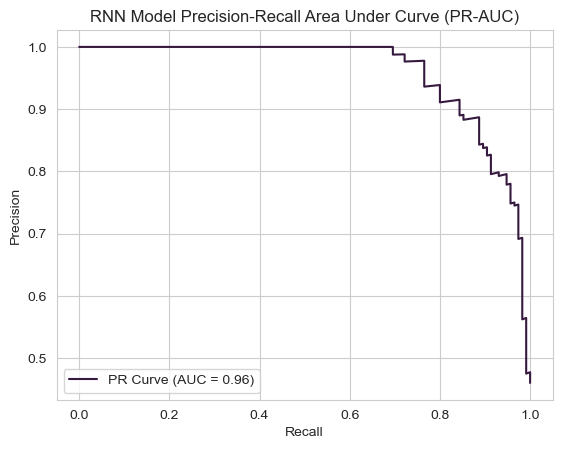

In [73]:
# Predict the probabilities
y_pred_probs = model.predict(X_test)

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Calculate PR AUC
rnn_pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure()
plt.plot(recall, precision, label='PR Curve (AUC = %0.2f)' % rnn_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RNN Model Precision-Recall Area Under Curve (PR-AUC)')
plt.legend(loc="lower left")
plt.show()

### ii) Compare RNN with non neural models

In [74]:
#Recheck metrics by predicting on X_test data, and converting probabilities to classes:
y_pred_prob = model.predict(X_test)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Score best estimator
rnn_accuracy = accuracy_score(y_test, y_pred_class)
rnn_recall = recall_score(y_test, y_pred_class)
rnn_precision = precision_score(y_test, y_pred_class)
rnn_f1 = f1_score(y_test, y_pred_class)


8/8 [==============================] - 0s 30ms/step


In [75]:
#Append results to the model comparison dataframe:

rnn_report = {
    'Model': 'RNN',
    'Train Duration': rnn_duration,
    'Test Accuracy': rnn_accuracy,
    'Test Recall': rnn_recall,
    'Test Precision': rnn_precision,
    'Test F1': rnn_f1,
    'Test PR AUC': rnn_pr_auc}

rnn_report = pd.DataFrame([rnn_report])
results_df = pd.concat([results_df, rnn_report], ignore_index=True).round(3)
results_df

,Model,Train Duration,Test Accuracy,Test Recall,Test Precision,Test F1,Test PR AUC
0,Naive Bayes,0.348,0.744,0.583,0.807,0.677,0.826
1,Decision Tree,8.689,0.684,0.330,0.950,0.490,0.817
2,Logistic Regression,0.883,0.796,0.765,0.786,0.775,0.865
3,SVC,2.115,0.784,0.635,0.859,0.730,0.867
4,RNN,544.263,0.856,0.922,0.797,0.855,0.959


In [76]:
display(Markdown(f"Based on the final comparison table, we can see that the RNN model has improved performance based on the F1 score of {rnn_f1:0.3f} compared to the best performing non-neural model Logistic Regression with an F1 score of {lr_f1:.3f}, as well as an improved PR-AUC score of {rnn_pr_auc: 0.03f} compared with {svc_pr_auc: 0.03f}."))

Based on the final comparison table, we can see that the RNN model has improved performance based on the F1 score of 0.855 compared to the best performing non-neural model Logistic Regression with an F1 score of 0.775, as well as an improved PR-AUC score of  0.959 compared with  0.867.

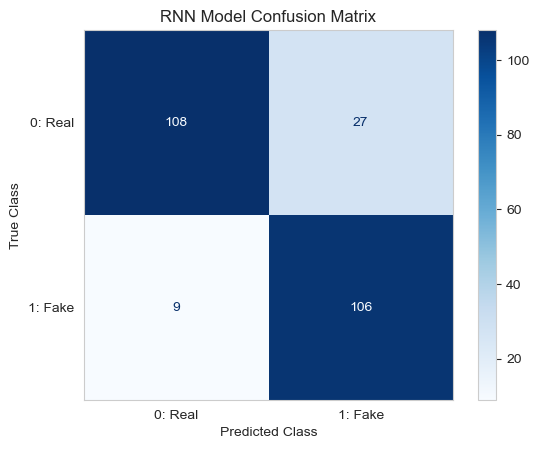

In [77]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

#Extract false positives
rnn_FP = conf_matrix[0][1]
#Extract false negatives
rnn_FN = conf_matrix[1][0]

# Plot the confusion matrix 
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0: Real', '1: Fake']).plot(values_format='d', cmap='Blues')
plt.title('RNN Model Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.grid(False)
plt.show()

In [78]:
display(Markdown(f"Reviewing the confusion matrix, we can more clearly understand that the RNN model has changed the number of:\n\n - False Positives (Real news incorrectly identified as Fake) from {lr_FP} to {rnn_FP} \n\n - False Negatives (Fake news incorrectly identified as Real) from {lr_FN} to {rnn_FN} \n\nwhen compared with the best performing non neural network (Logistic Regression)."))

Reviewing the confusion matrix, we can more clearly understand that the RNN model has changed the number of:

 - False Positives (Real news incorrectly identified as Fake) from 24 to 27 

 - False Negatives (Fake news incorrectly identified as Real) from 27 to 9 

when compared with the best performing non neural network (Logistic Regression).